In [1]:
# Jupyter notebook for generating LC-21T libary of Phycosphere samples
# RMB update 4/05/2023
# Contributors: Yuri Corilo, Will Kew, Christian Dewey, Rene Boiteau

##########

# Import the os module
import os
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("./")
from pathlib import Path

# Change the current working directory

#os.chdir('../..')
os.chdir('/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS')
         
# Set file folder and THERMO RAW file name here:
file_location='/Users/boiteaur/Desktop/Major projects/Phycosphere LCMS'
file="20221031_LBA_Boiteau_Zorbax3p5_AZTDpooled_T7_02" #pooled sample for formula assignments
bfile="20221101_LBA_Boiteau_Zorbax3p5_Water_33" #blank sample
refmasslist = Path.cwd() / "tests/tests_data/ftms/siloxanes_pos.ref"

# Import required modules
import matplotlib.pyplot as plt
from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration
import matplotlib.backends.backend_pdf

# Set peak detection threshold method
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 20
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

#MSParameters.molecular_search.ion_charge = +1

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

# Read in sample list and load MS data
MSfiles={}

parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+file)
bparser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+bfile)

MSfiles[file]=parser
#MSfiles[bfile]=bparser


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


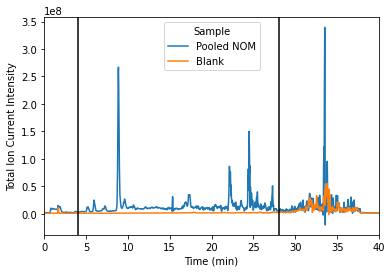

In [2]:
#Plot total ion chromatograms to evaluate useful time range. 

tic=parser.get_tic(ms_type='MS')[0]
btic=bparser.get_tic(ms_type='MS')[0]

#tic_df=pd.DataFrame({'Time': tic.time,'Intensity': tic.tic,'Sample':'Pooled NOM'})
tic_df=pd.DataFrame({'Time': tic.time,'Intensity': tic.tic,'Sample':'Pooled NOM'})
btic_df=pd.DataFrame({'Time': btic.time,'Intensity': btic.tic,'Sample':'Blank'})

tic_df=pd.concat([tic_df,btic_df])
tic_df=tic_df.reset_index()

fig, (ax) = plt.subplots(1)
sns.lineplot(x='Time',y='Intensity',data=tic_df,ax=ax, hue='Sample')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Total Ion Current Intensity')
ax.set_xlim(0,40)
ax.axvline(x=4,color='black')
ax.axvline(x=28,color='black')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.savefig(file_location+'CoreLCMS_FigS1.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_FigS1.pdf',dpi=300,format='pdf')



In [3]:

#Function to build formula assignment lists
interval=2
timerange=[4,24]

B=21 #magnetic field strength
T=0.6 #transient time

def lcmsformula(parser,interval,timerange):
    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        #Now, get an average mass spectrum and list the centroided m/z values of the spectrum. One of these should be the molecule of interest.
        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)
        mass_spectrum.filter_by_min_resolving_power(B, T)
    
        mass_spectrum.settings.min_calib_ppm_error = 2
        mass_spectrum.settings.max_calib_ppm_error = -2

        calfn = MzDomainCalibration(mass_spectrum, refmasslist)
        ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

        imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                    calib_ppm_error_threshold=(-2.0, 2.0),
                                                    calib_snr_threshold=5)

        calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=1)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
    
    results=pd.concat(results,ignore_index=True)

    return(results)

#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = 0
MSParameters.molecular_search.max_dbe = 18

#First, evaluate wide attribution criteria
MSParameters.molecular_search.usedAtoms['C'] = (4,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,8)
MSParameters.molecular_search.usedAtoms['S'] = (0,1)
MSParameters.molecular_search.usedAtoms['P'] = (0,0)
MSParameters.molecular_search.usedAtoms['Na'] = (0,0)


#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_df=pd.concat(masterresults.values())
masterresults_df.to_csv(file_location+'/'+'Phycosphere LCMSpooled_results_wide.csv')

20221031_LBA_Boiteau_Zorbax3p5_AZTDpooled_T7_02
MS Obj loaded - 216 peaks found.
MS Obj loaded - 216 peaks found.
Reference mass list loaded - 10 calibration masses loaded.
8 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.208 ppm
minimize function performed 138 fn evals and 3 iterations
'runworker'  1265.98 ms


Loading molecular formula database: 195100it [00:12, 15628.55it/s]
Started molecular formula search for class {"N": 7, "S": 1, "O": 10}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 81.88it/s] 
Loading molecular formula database: 42912it [00:03, 12568.24it/s]
Started molecular formula search for class {"N": 8, "S": 1, "O": 20}, (de)protonated : 100%|██████████| 60/60 [00:00<00:00, 246.85it/s]


'run_molecular_formula'  21244.48 ms
127 assigned peaks and 89 unassigned peaks, total  = 58.80 %, relative abundance = 75.80 %, RMS error (best candidate) (ppm) = 0.118
MS Obj loaded - 439 peaks found.
MS Obj loaded - 439 peaks found.
Reference mass list loaded - 10 calibration masses loaded.
9 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.229 ppm
minimize function performed 139 fn evals and 3 iterations
'runworker'  1112.25 ms


Loading molecular formula database: 195100it [00:13, 14219.02it/s]
Started molecular formula search for class {"N": 7, "S": 1, "O": 10}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 65.11it/s]
Loading molecular formula database: 42912it [00:03, 12488.49it/s]
Started molecular formula search for class {"N": 8, "S": 1, "O": 20}, (de)protonated : 100%|██████████| 60/60 [00:00<00:00, 165.53it/s]


'run_molecular_formula'  23448.67 ms
251 assigned peaks and 188 unassigned peaks, total  = 57.18 %, relative abundance = 66.78 %, RMS error (best candidate) (ppm) = 0.112
MS Obj loaded - 6 peaks found.
MS Obj loaded - 6 peaks found.
Reference mass list loaded - 10 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  1187.39 ms


Loading molecular formula database: 195100it [00:10, 19432.92it/s] 
Started molecular formula search for class {"N": 7, "S": 1, "O": 10}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 611.00it/s]
Loading molecular formula database: 42912it [00:02, 17299.94it/s]
Started molecular formula search for class {"N": 8, "S": 1, "O": 20}, (de)protonated : 100%|██████████| 60/60 [00:00<00:00, 625.02it/s]


'run_molecular_formula'  14375.82 ms
4 assigned peaks and 2 unassigned peaks, total  = 66.67 %, relative abundance = 70.22 %, RMS error (best candidate) (ppm) = 0.158
MS Obj loaded - 215 peaks found.
MS Obj loaded - 215 peaks found.
Reference mass list loaded - 10 calibration masses loaded.
7 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.226 ppm
minimize function performed 141 fn evals and 3 iterations
'runworker'  1118.53 ms


Loading molecular formula database: 195100it [00:13, 14587.44it/s]
Started molecular formula search for class {"N": 7, "S": 1, "O": 10}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 249.38it/s]
Loading molecular formula database: 42912it [00:02, 20367.78it/s]
Started molecular formula search for class {"N": 8, "S": 1, "O": 20}, (de)protonated : 100%|██████████| 60/60 [00:00<00:00, 275.23it/s]


'run_molecular_formula'  18243.82 ms
112 assigned peaks and 103 unassigned peaks, total  = 52.09 %, relative abundance = 55.38 %, RMS error (best candidate) (ppm) = 0.149
MS Obj loaded - 685 peaks found.
MS Obj loaded - 685 peaks found.
Reference mass list loaded - 10 calibration masses loaded.
8 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.205 ppm
minimize function performed 140 fn evals and 3 iterations
'runworker'  1458.93 ms


Loading molecular formula database: 195100it [00:18, 10722.54it/s]
Started molecular formula search for class {"N": 7, "S": 1, "O": 10}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 104.53it/s]
Loading molecular formula database: 42912it [00:02, 15439.43it/s]
Started molecular formula search for class {"N": 8, "S": 1, "O": 20}, (de)protonated : 100%|██████████| 60/60 [00:00<00:00, 120.37it/s]


'run_molecular_formula'  26194.01 ms
296 assigned peaks and 389 unassigned peaks, total  = 43.21 %, relative abundance = 51.12 %, RMS error (best candidate) (ppm) = 0.134
MS Obj loaded - 108 peaks found.
MS Obj loaded - 108 peaks found.
Reference mass list loaded - 10 calibration masses loaded.
6 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 1030 fn evals and 36 iterations
'runworker'  1252.72 ms


Loading molecular formula database: 195100it [00:11, 16983.10it/s]
Started molecular formula search for class {"N": 7, "S": 1, "O": 10}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 356.96it/s]
Loading molecular formula database: 42912it [00:02, 16233.84it/s]
Started molecular formula search for class {"N": 8, "S": 1, "O": 20}, (de)protonated : 100%|██████████| 60/60 [00:00<00:00, 333.40it/s]


'run_molecular_formula'  16541.41 ms
72 assigned peaks and 36 unassigned peaks, total  = 66.67 %, relative abundance = 71.41 %, RMS error (best candidate) (ppm) = 0.101
MS Obj loaded - 204 peaks found.
MS Obj loaded - 204 peaks found.
Reference mass list loaded - 10 calibration masses loaded.
6 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.048 ppm
minimize function performed 920 fn evals and 32 iterations
'runworker'  1152.63 ms


Loading molecular formula database: 195100it [00:12, 15773.39it/s]
Started molecular formula search for class {"N": 7, "S": 1, "O": 10}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 239.43it/s]
Loading molecular formula database: 42912it [00:03, 12342.67it/s]
Started molecular formula search for class {"N": 8, "S": 1, "O": 20}, (de)protonated : 100%|██████████| 60/60 [00:00<00:00, 279.07it/s]


'run_molecular_formula'  18616.23 ms
141 assigned peaks and 63 unassigned peaks, total  = 69.12 %, relative abundance = 74.25 %, RMS error (best candidate) (ppm) = 0.104
MS Obj loaded - 1063 peaks found.
MS Obj loaded - 1063 peaks found.
Reference mass list loaded - 10 calibration masses loaded.
9 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.185 ppm
minimize function performed 135 fn evals and 3 iterations
'runworker'  1155.32 ms


Loading molecular formula database: 195100it [00:15, 12671.65it/s]
Started molecular formula search for class {"N": 7, "S": 1, "O": 10}, (de)protonated : 100%|██████████| 300/300 [00:07<00:00, 40.57it/s]
Loading molecular formula database: 42912it [00:04, 9911.25it/s] 
Started molecular formula search for class {"N": 8, "S": 1, "O": 20}, (de)protonated : 100%|██████████| 60/60 [00:00<00:00, 85.68it/s]


'run_molecular_formula'  29239.73 ms
714 assigned peaks and 349 unassigned peaks, total  = 67.17 %, relative abundance = 79.00 %, RMS error (best candidate) (ppm) = 0.142
MS Obj loaded - 550 peaks found.
MS Obj loaded - 550 peaks found.
Reference mass list loaded - 10 calibration masses loaded.
7 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.051 ppm
minimize function performed 288 fn evals and 9 iterations
'runworker'  1343.27 ms


Loading molecular formula database: 195100it [00:13, 14363.18it/s]
Started molecular formula search for class {"N": 7, "S": 1, "O": 10}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 110.75it/s]
Loading molecular formula database: 42912it [00:04, 10395.14it/s]
Started molecular formula search for class {"N": 8, "S": 1, "O": 20}, (de)protonated : 100%|██████████| 60/60 [00:00<00:00, 201.86it/s]


'run_molecular_formula'  22216.94 ms
374 assigned peaks and 176 unassigned peaks, total  = 68.00 %, relative abundance = 80.22 %, RMS error (best candidate) (ppm) = 0.093
MS Obj loaded - 98 peaks found.
MS Obj loaded - 98 peaks found.
Reference mass list loaded - 10 calibration masses loaded.
3 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.014 ppm
minimize function performed 2012 fn evals and 73 iterations
'runworker'  1232.70 ms


Loading molecular formula database: 195100it [00:12, 15970.41it/s]
Started molecular formula search for class {"N": 7, "S": 1, "O": 10}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 299.78it/s]
Loading molecular formula database: 42912it [00:01, 27519.00it/s]
Started molecular formula search for class {"N": 8, "S": 1, "O": 20}, (de)protonated : 100%|██████████| 60/60 [00:00<00:00, 389.51it/s]


'run_molecular_formula'  16312.29 ms
71 assigned peaks and 27 unassigned peaks, total  = 72.45 %, relative abundance = 84.58 %, RMS error (best candidate) (ppm) = 0.065


PermissionError: [Errno 13] Permission denied: '/Users/boiteaur/Desktop/Major projects/Phycosphere LCMS/Phycosphere LCMSpooled_results_wide.csv'

In [4]:
masterresults_df.to_csv(file_location+'/'+'Phycosphere LCMSpooled_results_wide.csv')

3565
2155
1410
Unique molecular formula #: 1270
Unique m/z peaks: 2045
All assignments: 1793
Good assignments: 1635
Questionable assignments: 520


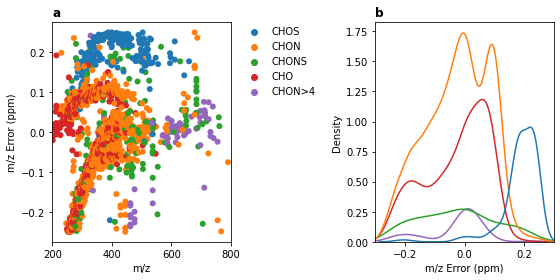

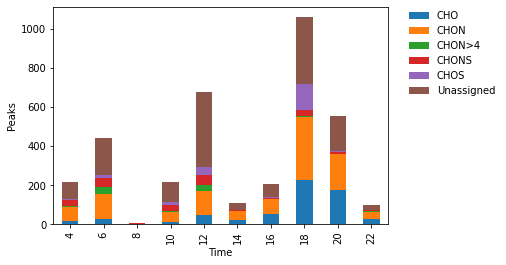

In [5]:
masterresults_df=pd.read_csv(file_location+'/'+'Phycosphere LCMSpooled_results_wide.csv')

# Plot clean results. 

allresults=masterresults_df[(masterresults_df['m/z']<800)]
#allresults=allresults[allresults['Peak Height']>2000]
allresults=allresults[allresults['File']==file]

allresults['N']=allresults['N'].fillna(0)
allresults['O']=allresults['O'].fillna(0)
allresults['S']=allresults['S'].fillna(0)
#allresults['P']=allresults['P'].fillna(0)
#allresults['Na']=allresults['Na'].fillna(0)

allresults['Molecular class']='Unassigned'
allresults['Molecular class'][allresults['C']>0]='CHO'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>4.5)]='CHON>4'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['P']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['Na']>0.5)]='CHONa'
allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5)]='CHOS'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5)]='CHONS'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['P']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['P']>0.5)]='CHOSP'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['Na']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['Na']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5) & (allresults['P']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5) & (allresults['Na']>0.5)]='CHONSNa'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='CHONPNa'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='CHONSNa'

print(len(allresults))
print(len(allresults[allresults['Molecular class']!='Unassigned']))
print(len(allresults[allresults['Molecular class']=='Unassigned']))

results=allresults[allresults['Is Isotopologue']==0]
results=allresults[allresults['Molecular class']!='Unassigned']

results_1=results[(results['Molecular class'].isin(['CHO','CHON']))]
results_2=results[(~results['Molecular class'].isin(['CHO','CHON']))]

#results_2=results[(results['Molecular class']!='CHO') | (results['Molecular class']!='CHON<4')]

results= allresults[allresults['Is Isotopologue']==0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']

# Calculate Nominal Oxidation State of Carbon (NOSC)
results['NOSC'] =  4 -(4*results['C'] + results['H'] - 3*results['N'] - 2*results['O'])/results['C']




Assignedlist=masterresults_df[(masterresults_df['m/z']<800)]
print('Unique molecular formula #:', len(Assignedlist['Molecular Formula'].unique()))
print('Unique m/z peaks:', len(masterresults_df['m/z'].round(3).unique()))

print('All assignments:', len(results))
print('Good assignments:', len(results_1))
print('Questionable assignments:', len(results_2))




fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(8, 4)


sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='Molecular class',data=results,ax=ax1, edgecolor='none')

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
ax1.set_xlim(200,800)
ax1.set_title('a', fontweight='bold', loc='left')

sns.kdeplot(x='m/z Error (ppm)',data=results,hue='Molecular class',ax=ax2,legend=False)
ax2.set_xlim(-0.3,0.3)
ax2.set_title('b', fontweight='bold', loc='left')

fig.tight_layout()

fig.savefig(file_location+'CoreLCMS_FigS3.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_FigS3.pdf',dpi=300,format='pdf')

assign_summary=[]

for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['Molecular class'].unique()):
        current[mol_class]=len(allresults[(allresults['Molecular class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)
df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)



plt.show()

In [10]:
### Use masterresults library to annotate MZmine3 feature list

featurelist=pd.read_csv(file_location+'/'+'mzmine_21Tdata_round1.csv')
featurelist2=featurelist
featurelist2['Molecular Formula']= None
#print(featurelist)
timebins=masterresults_df.Time.unique()

masterresults={}

for i in featurelist.iterrows():
    #print(i[0])
    time=i[1].rt
    mass=i[1].mz
    match=(timebins-time)
    match=round(match[match<1].min()+time)
    

    #### Core feature extraction function.


for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_2_df=pd.concat(masterresults.values())
masterresults_2_df.to_csv(file_location+'pooled_results_narrow.csv')



    formula=masterresults_df[abs(masterresults_df['Calculated m/z']-mass)<0.001]
    formula=formula[formula.Time==match]['Molecular Formula'].to_list()
    print(formula)
    if formula:
        print('ok')
        featurelist2.iloc[i[0]]['Molecular Formula']=formula

print(featurelist2['Molecular Formula'])

[]
['C12 H18 O4 S1 N4']
ok
['C12 H18 O2 S1 N4']
ok
['C15 H21 O4 N1']
ok
['C19 H31 O8 N1']
ok
['C12 H20 O3 N4']
ok
['C12 H18 O3 N4']
ok
[]
[]
['C12 H16 O3 S1 N4']
ok
['C12 H18 O3 S1 N4']
ok
['C12 H16 O3 N4 34S1']
ok
['C12 H18 O2 S1 N4']
ok
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['C12 H16 O3 S1 N4']
ok
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['C12 H16 O2 S1 N4']
ok
[]
[]
[]
[]
[]
[]
['C12 H14 O2 S1 N4']
ok
[]
[]
[]
[]
['C12 H16 O2 S1 N4']
ok
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['C12 H18 O2 S1 N4']
ok
[]
[]
[]
[]
[]
[]
['C12 H16 O2 S1 N4']
ok
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['C12 H14 O2 S1 N4']
ok
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['C20 H37 O4 N1']
ok
[]
['C15 H29 O6 N1']
ok
[]
[]
[]
[]
[]
[]
['C15 H29 O6 N1']
ok
[]
[]
[]
[]
[]
[]
[]
['C15 H29 O6 N1']

In [8]:
print(featurelist2['Molecular Formula'])

0      None
1      None
2      None
3      None
4      None
       ... 
347    None
348    None
349    None
350    None
351    None
Name: Molecular Formula, Length: 352, dtype: object


In [ ]:
masterresults_df=pd.read_csv(file_location+'/'+'Phycosphere LCMSpooled_results_wide.csv')

# Plot clean results. 

allresults=masterresults_df[(masterresults_df['m/z']<800)]
#allresults=allresults[allresults['Peak Height']>2000]
allresults=allresults[allresults['File']==file]

allresults['N']=allresults['N'].fillna(0)
allresults['O']=allresults['O'].fillna(0)
#allresults['S']=allresults['S'].fillna(0)
#allresults['P']=allresults['P'].fillna(0)
#allresults['Na']=allresults['Na'].fillna(0)

allresults['Molecular class']='Unassigned'
allresults['Molecular class'][allresults['C']>0]='CHO'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>4.5)]='CHON>4'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['P']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['Na']>0.5)]='CHONa'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5)]='CHOS'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5)]='CHONS'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['P']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['P']>0.5)]='CHOSP'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['Na']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['Na']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5) & (allresults['P']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5) & (allresults['Na']>0.5)]='CHONSNa'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='CHONPNa'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='CHONSNa'

print(len(allresults))
print(len(allresults[allresults['Molecular class']!='Unassigned']))
print(len(allresults[allresults['Molecular class']=='Unassigned']))

results=allresults[allresults['Is Isotopologue']==0]
results=allresults[allresults['Molecular class']!='Unassigned']

results_1=results[(results['Molecular class'].isin(['CHO','CHON']))]
results_2=results[(~results['Molecular class'].isin(['CHO','CHON']))]

#results_2=results[(results['Molecular class']!='CHO') | (results['Molecular class']!='CHON<4')]

results= allresults[allresults['Is Isotopologue']==0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']

# Calculate Nominal Oxidation State of Carbon (NOSC)
results['NOSC'] =  4 -(4*results['C'] + results['H'] - 3*results['N'] - 2*results['O'])/results['C']




Assignedlist=masterresults_df[(masterresults_df['m/z']<800)]
print('Unique molecular formula #:', len(Assignedlist['Molecular Formula'].unique()))
print('Unique m/z peaks:', len(masterresults_df['m/z'].round(3).unique()))

print('All assignments:', len(results))
print('Good assignments:', len(results_1))
print('Questionable assignments:', len(results_2))




fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(8, 6)


sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='Molecular class',data=results_1,ax=ax1, edgecolor='none')

ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
ax1.set_xlim(200,800)
ax1.set_title('a', fontweight='bold', loc='left')

sns.kdeplot(x='m/z Error (ppm)',data=results_1,hue='Molecular class',ax=ax2,legend=False)
ax2.set_xlim(-0.3,0.3)
ax2.set_title('b', fontweight='bold', loc='left')

sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='Molecular class',data=results_2,ax=ax3, edgecolor='none')
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
ax3.set_xlim(200,800)
ax3.set_title('c', fontweight='bold', loc='left')

sns.kdeplot(x='m/z Error (ppm)',data=results_2,hue='Molecular class',ax=ax4,legend=False)
ax4.set_xlim(-0.3,0.3)
ax4.set_title('d', fontweight='bold', loc='left')

fig.tight_layout()

fig.savefig(file_location+'CoreLCMS_FigS3.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_FigS3.pdf',dpi=300,format='pdf')

assign_summary=[]

for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['Molecular class'].unique()):
        current[mol_class]=len(allresults[(allresults['Molecular class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)
df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)



plt.show()

In [ ]:

#Calculate Dispersity Index. 
EIC={}
for file in uniqueresults['File'].unique():
    masses=uniqueresults[uniqueresults['File']==file]['m/z'].unique().tolist()
    EIC[file]=MSfiles[file].get_eics(target_mzs=masses,tic_data={},peak_detection=False,smooth=False)
    
dispersity=[]
for ind in uniqueresults.index:
    current=uniqueresults.loc[ind]
    time=[0,2]+current.Time
    file=current.File
    mass=current['m/z']
    chroma=pd.DataFrame({'EIC':EIC[file][0][mass].eic,'time':EIC[file][0][mass].time})
    chroma=chroma[chroma['time'].between(time[0],time[1])]
    chroma=chroma.sort_values(by='EIC',ascending=False)
    d=chroma[chroma.cumsum()['EIC']<0.5*chroma.sum()['EIC']].time.std()
    dispersity.append(d)

uniqueresults['Dispersity']=dispersity


In [ ]:
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 
#Function to build formula assignment lists
interval=4
timerange=[6,18]

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = 0
MSParameters.molecular_search.max_dbe = 20

#Second, evaluate narrow attribution criteria
MSParameters.molecular_search.usedAtoms['C'] = (4,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,5)
MSParameters.molecular_search.usedAtoms['S'] = (0,1)
MSParameters.molecular_search.usedAtoms['P'] = (0,0)
MSParameters.molecular_search.usedAtoms['Na'] = (0,0)

Heteroatoms=['N']

#MSpeak highest confidence molecular formula. 

#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_2_df=pd.concat(masterresults.values())
masterresults_2_df.to_csv(file_location+'pooled_results_narrow.csv')

In [ ]:
# Plot formula assignment details
allresults=masterresults_2_df[(masterresults_2_df['m/z']<800) & (masterresults_2_df['S/N']>2)]

allresults['O']=allresults['O'].fillna(0)

for element in Heteroatoms:
    allresults[element]=allresults[element].fillna(0)

allresults['mol_class']='Unassigned'
allresults['mol_class'][allresults['C']>0]='CHO'
allresults['mol_class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'

results=allresults[allresults['Is Isotopologue']==0]


print('Average Total:', len(masterresults_df)/len(MSfiles))
print('Unique  molecular formula #:', len(masterresults_df['Molecular Formula'].unique()))
Assignedlist=masterresults_df[(masterresults_df['m/z']<800)]
print('Unique good molecular formula #:', len(Assignedlist['Molecular Formula'].unique()))
print('Unique m/z peaks:', len(masterresults_df['m/z'].round(3).unique()))


fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(7, 3)

sns.kdeplot(x='m/z Error (ppm)',data=results,hue='mol_class',ax=ax1,legend=False)
ax1.set_xlim(-0.3,0.3)
sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='mol_class',data=results,ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
fig.tight_layout()


assign_summary=[]

for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['mol_class'].unique()):
        current[mol_class]=len(allresults[(allresults['mol_class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')


plt.show()
